In [1]:
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading in data 
adj =  np.genfromtxt('Inputs/adj.csv', delimiter=',', dtype=np.int8)
data = np.genfromtxt('Inputs/data.csv', delimiter=',')

In [3]:
data.shape

(150000, 16)

In [3]:
tetrode_adj = [
    [0, 1],
    [1, 0], 
    [0, 4], 
    [4, 0],
    [1, 5],
    [5, 1],
    [4, 5], 
    [5, 4], 
    
    [2, 3],
    [3, 2], 
    [2, 6], 
    [6, 2],
    [3, 7],
    [7, 3],
    [6, 7],
    [7, 6],
    
    [8, 9],
    [9, 8],
    [8, 12],
    [12, 8],
    [9, 13],
    [13, 9],
    [12, 13],
    [13, 12],
    
    [10, 11],
    [11, 10],
    [10, 14],
    [14, 10],
    [11, 15],
    [15, 11], 
    [14, 15],
    [15,14]
]

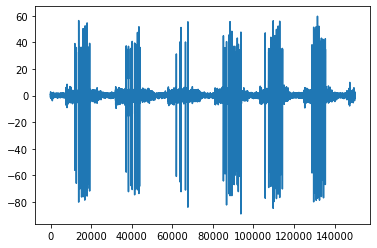

In [4]:
# Plotting the first channel 
plt.plot(data[:,1])
plt.show()

In [5]:
# Figuring out how to generate dummy data

# Sinusodal data
def gen_dummy_data():
    # TODO: Paramterize this so it can change size, perhaps function o_O
    return np.asarray([np.sin(np.arange(0,100,.1))]*16).transpose()
    
def gen_dummy_adj():
    # TODO: No clue, this is hard coded
    tmp = []
    for i in range(1,16,2):
        tmp.append([i-1, i])
        tmp.append([i, i-1])
    return np.asarray(tmp)


In [6]:
# Generating dummy data with unique spike templates 

# Generating spike times 
def gen_spike_times(numSpks, lim, numTemplates, numChans):
    """numSpks: # of spikes, lim: length of data, numTemplates: # of templates, numChans: # of channels"""
    spkTimes = []
    spkChans = []
    for i in range(numTemplates):
        spkTimes.append(np.random.choice(range(lim), numSpks, replace = False))
        spkChans.append(np.random.choice(range(numChans), numSpks, replace=True))
    return np.asarray(spkTimes), np.asarray(spkChans)

# Generating spike template
def gen_spike_templates(numSpks,muWidth=90,sigmaWidth=10, muFac=0.1, sigmaFac=0.02, muVert=200, sigmaVert=40):
    """
    numSpks: # of Spikes, muWidth: mean width of spike, sigmaWidth: stdev of spike width, muFac: mean width fator, 
    sigmaFac: stdev of spike factor, muVert: mean vertical scaling factor, sigmaVert: stdev of vertical scaling factor
    """
    from scipy import signal 
    
    waveforms = []
    
    for i in range(numSpks):
        width = sigmaWidth * np.random.randn() + muWidth 
        factor = (np.abs(sigmaFac*np.random.randn()+muFac))*width
        polarity = np.random.choice([1,-1], 1)[0]
        vertical = sigmaVert*np.random.randn()+muVert
        # Add a linear equations on top | super impose multiple rickers
        waveforms.append(polarity*signal.ricker(width, factor)*vertical)
    return np.asarray(waveforms, dtype=object)

In [7]:
# Plotting of waveforms 
def plot_waveforms(wave):
    fig, axs = plt.subplots(4,4)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    plt.grid=True
    
    # Loop variables 
    count, minY, maxY = 0, float('inf'), -float('inf') 
    
    for i in range(4):
        for j in range(4):
            axs[i][j].plot(wave[count])
            minY = min(min(wave[count]),minY)
            maxY = max(max(wave[count]),maxY)
            count += 1
    
    # Updating Y scale 
    for i in range(4):
        for j in range(4):
            axs[i][j].set_ylim((minY-1, maxY+1))
    
    plt.show()
    return fig, axs

In [8]:
# Generating dummy data set with cool hats 
def generate_hat_data(numSpks, lim, numTemplates, numChans, muWidth=90, sigmaWidth=10, muFac=0.1, sigmaFac=0.02, muVert=25, sigmaVert=5, seed = False):
    if seed:
        np.random.seed(1738)
    
    times, chans = gen_spike_times(numSpks, lim, numTemplates, numChans)
    
    waveforms = gen_spike_templates(numTemplates, muWidth, sigmaWidth, muFac, sigmaFac, muVert, sigmaVert)
    
    # Generating zeros matrix 
    tmp = np.zeros((numChans, lim))
    spikes_inserted = []
    
    for i in range(numTemplates):
        for j in range(numSpks):
            wave = waveforms[i]
            spkTime = times[i][j]
            spkChan = chans[i][j]
            radius = wave.shape[0]//2
            if spkTime - radius > 0 and spkTime + radius + 1 < lim: 
                if wave.shape[0] % 2 == 0:
                    tmp[spkChan][spkTime-radius:spkTime+radius] += wave
                else:
                    tmp[spkChan][spkTime-radius:spkTime+radius+1] += wave
                
                spikes_inserted.append([i,spkTime,spkChan])
    return tmp, np.asarray(spikes_inserted)
            

def insert_spike():
    pass

dummy_data, dummy_spikes = generate_hat_data(10, 1000, 10, 16, seed=True)

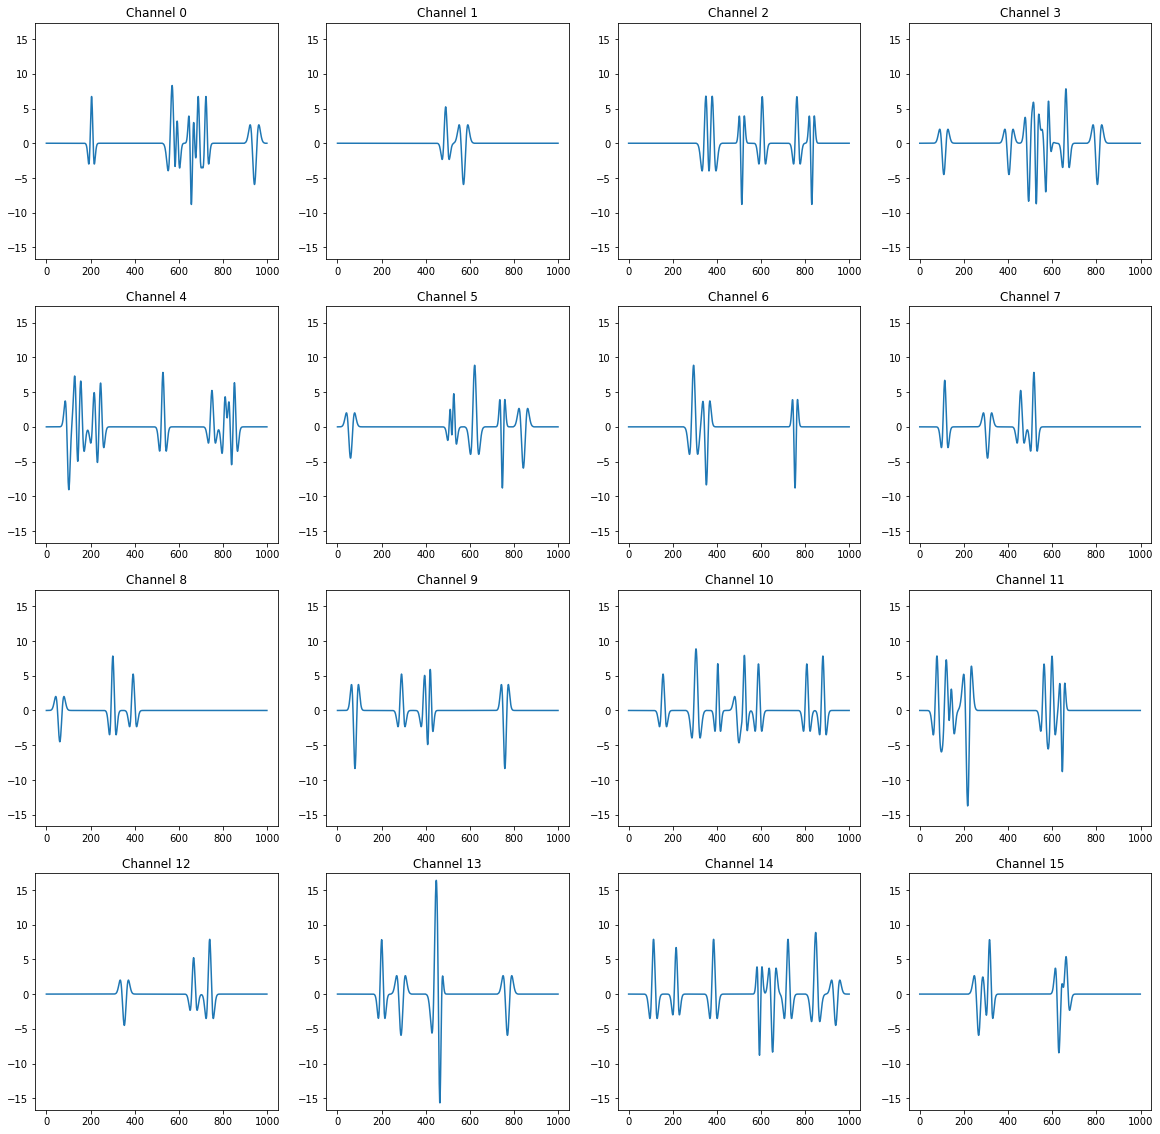

In [9]:
def plot_dummy_data(data):
    fig, axs = plt.subplots(4,4)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    plt.grid=True
    
    # Loop variables 
    count, minY, maxY = 0, float('inf'), -float('inf') 
    
    for i in range(4):
        for j in range(4):
            axs[i][j].plot(data[count])
            axs[i][j].set_title("Channel {}".format(count))
            minY = min(min(data[count]),minY)
            maxY = max(max(data[count]),maxY)
            count+= 1 
    
    # Updating Y scale 
    for i in range(4):
        for j in range(4):
            axs[i][j].set_ylim((minY-1, maxY+1))
    
    plt.show()
    return fig, axs
a,b = plot_dummy_data(dummy_data)

In [10]:
"""
NOTE: Hard coding for {(0,1), (2,3) ...} adjacency matrix
Psuedo code for new synthetic data creation

# PARAMS
* # of channels, # of templates per channel, # of spikes per template
* Decay factor, offset factor
* Waveform factors: spkHeight, spkWidth 

# SETUP STEPS
* Create empty array (num samples x num channels)

# GENERATE WAVEFORMS 
* params: # of channels, # of templates, # of spikes per template
* opt params: decay factor, offset factor, waveform factors (spkHeight, spkWidth, etc.)
* Generate waveforms, store in np array of (voltage x width x # of templates)

# GENERATE SPIKETIMES
* Go through each waveform, assign it randomly to a channel 
* Extract it's adjacent channel, create a lead,follow channel pair
* Create a set of spike times for the lead channel, use offset param to shift it for follow channel
* Create this as a np array of (channel x # templates) [i,j] = lead / follow times
* Create an array (channel x # templates) [i,j] = scaling factor for template on specific channel
* Do this for each waveform, and have an np array of the above called spk times

# GENERATING DATA
* Iterate through each of the templates, pull out waveform, channel, spk times 
* Inject the appropriate spike into specified channel with specified decay factor
* Repeat for all waveforms
* Add gaussian noise across all channels (parametrize this) 

return data, spk times

"""
print('')

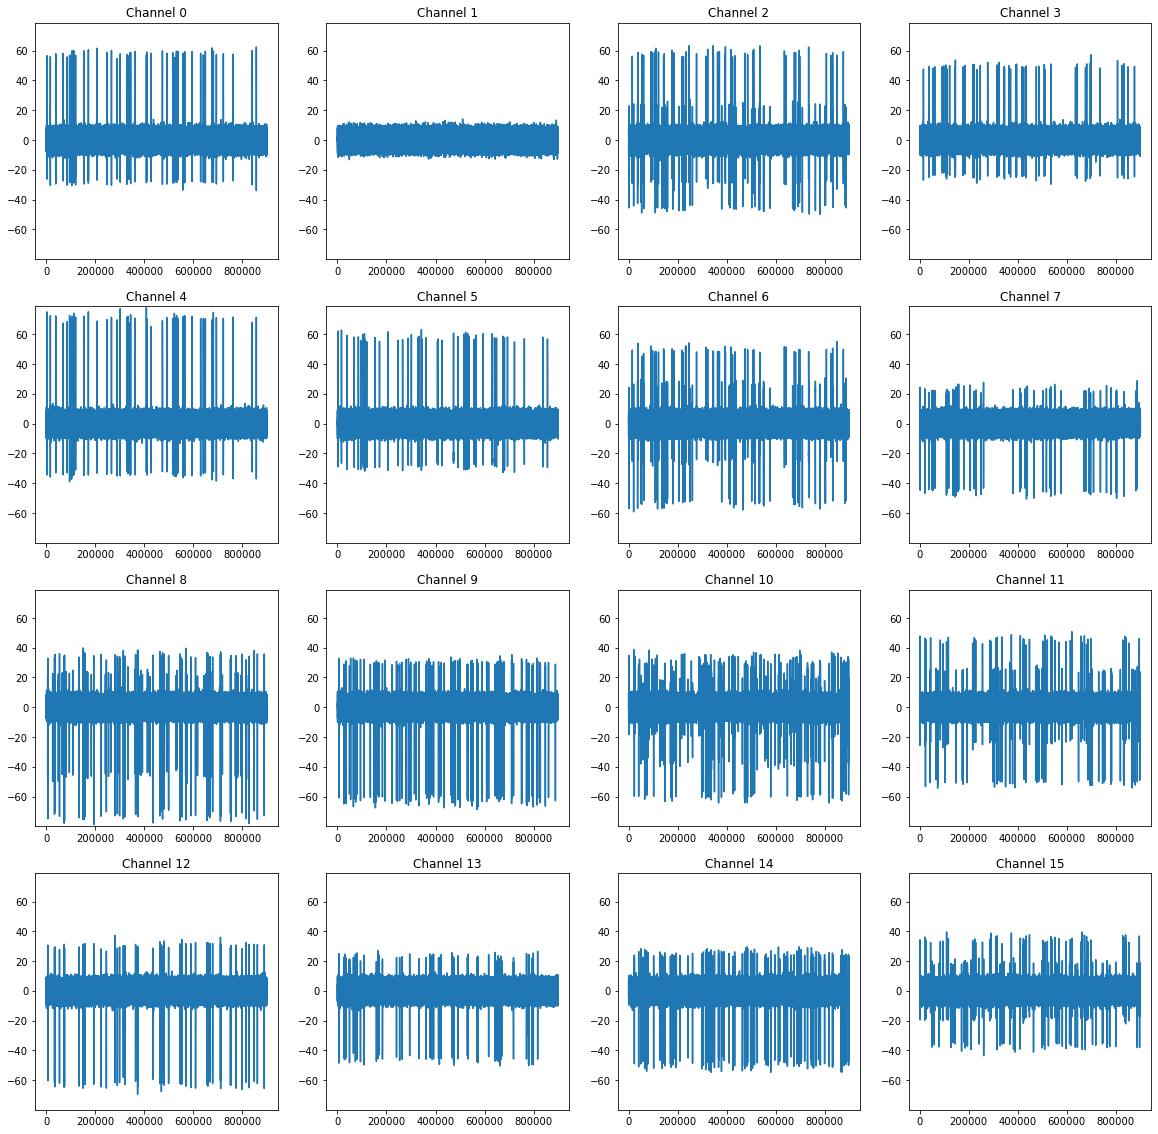

In [11]:
def gen_rel_data(N, adj, nChans, nSpks, nTemplates, offsetMu = 40, offsetSig = 5, decayMu = 0.8, decaySig = 0.05, noiseMu = 0, noiseSig = 1, seed=False, noise=True):
    if seed:
        np.random.seed(1738)
    
    # Setup Steps
    data = np.zeros(shape=(nChans, N))
    
    # Generate Waveforms 
    waveforms = gen_spike_templates(nTemplates)
    
    # Generate Spiketimes 
    # Creating lead - follow pairs
    chanAssign = np.random.choice(range(nChans), size=nChans, replace=False)
#     for i in range(nTemplates):
#         chanAssign.append(np.random.choice(range(nChans), replace=True))
    
    # Generating sets of spiking channels
    chans = []
    for x in chanAssign:
        tmp = [x]
        for pair in adj: 
            if pair[0] == x:
                tmp.append(pair[1])
        chans.append(tmp)

    # Assigning times to those pairs
    times = []
    for pair in chans:
        leadTimes = np.random.choice(range(100, N-100), nSpks, replace = False)
        offset = int(offsetSig*np.random.randn()+offsetMu)
        followTimes = leadTimes + offset
        times.append((leadTimes, followTimes))

    # Generating Data
    for i in range(nTemplates): 
        wave = waveforms[i]
        radius = wave.shape[0] // 2
        leadChan = chans[i][0]
        followChans = chans[i][1:]
        # Lead
        leadTimes = times[i][0]
        for t in leadTimes:
            if wave.shape[0] % 2 == 0:
                data[leadChan][t-radius:t+radius] += wave
            else:
                data[leadChan][t-radius:t+radius+1] += wave
        # Follow
        followTimes = times[i][1]
        decay = decaySig*np.random.randn() + decayMu
        for t in followTimes:
            if wave.shape[0] % 2 == 0:
                for followChan in followChans:
                    data[followChan][t-radius:t+radius] += wave*decay
            else:
                for followChan in followChans:
                    data[followChan][t-radius:t+radius+1] += wave*decay
        
        if noise:
            for channel in data:
                channel += noiseSig*np.random.randn(N,) + noiseMu
    return data
bruh = gen_rel_data(30*30000, tetrode_adj, 16, 50, 8, offsetMu = 20, seed=False) 
fig = plot_dummy_data(bruh)

/Users/samir/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


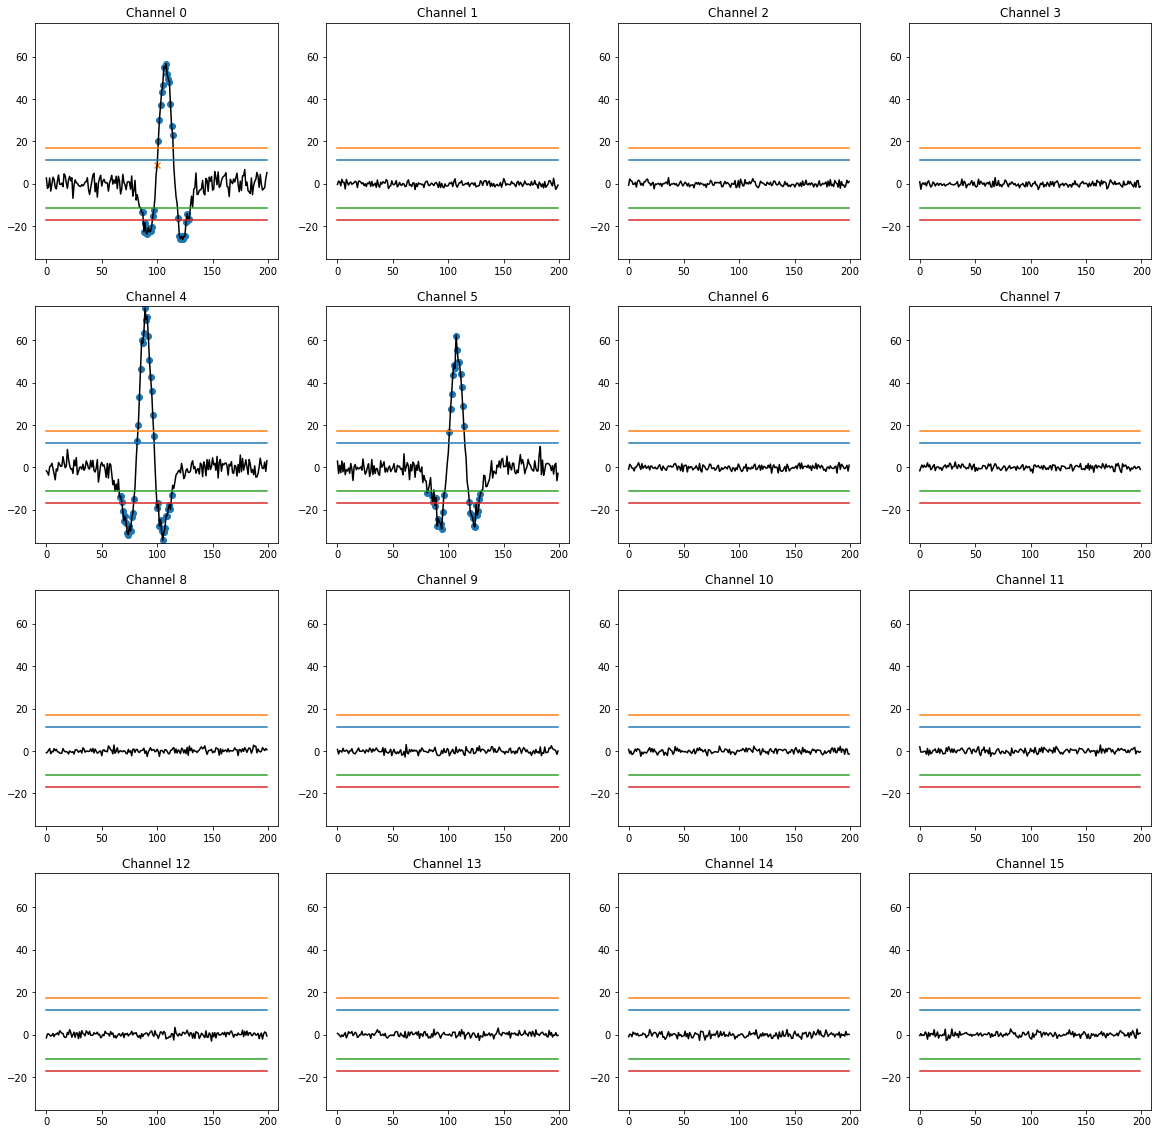

In [12]:
from flood import * 
# offsetMu = [15,20], offsetSig = 0, decayMu = 0.8, decaySig = 0.05, noiseMu = 0, noiseSig = 1
# Floodfill pre range check breaks at this point on inverted hat waveforms ^ 
ff = FloodFill(bruh.transpose(), tetrode_adj)
ff.detect_spikes(weakMul = 4, strongMul = 6, refr =10)
ff.plotSpk(0, wf=True, seed=True), len(ff.spk[0])
waves = ff.getWave(100)

In [18]:
ff.spk[1][0][0]

array([2273,    0])

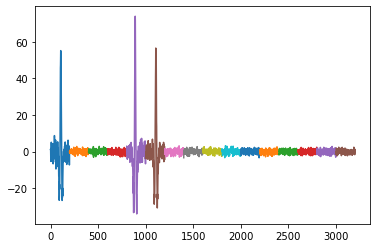

In [13]:
ff.plotWaves(30, 200)

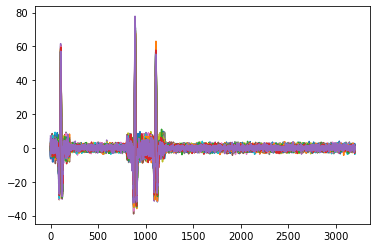

In [14]:
tp = np.asarray(ff.waves)
for i in range(25):
    plt.plot(ff.waves[i])

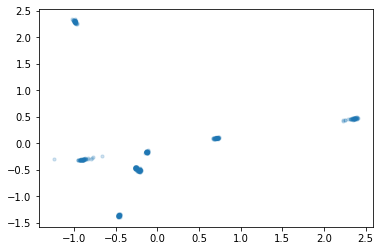

In [15]:
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA
pca = PCA(n_components=3, whiten= True)
pca.fit(waves)
pca_data = pca.transform(waves)
plt.scatter(pca_data[:, 0], pca_data[:, 1], 10, alpha = 0.2)
# # Creating figure
# fig = plt.figure(figsize = (10, 7))
# ax = plt.axes(projection ="3d")
 
# # Creating plot
# ax.scatter3D(pca_data[:,0], pca_data[:,1], pca_data[:,2], color = "green")
# plt.title("simple 3D scatter plot")
 
# # show plot
# plt.show()

In [16]:
ffReal = FloodFill(data, adj, p = 100)
ffReal.detect_spikes(refr=5)
print('pog')

/Users/samir/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


pog


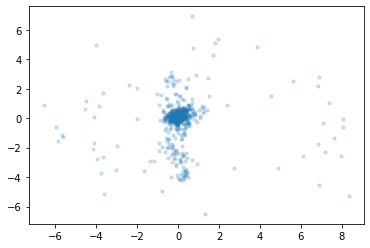

In [17]:
%matplotlib inline
waves = ffReal.getWave(100)
#tp = np.asarray(ffReal.waves)
#from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA
pca = PCA(n_components=3, whiten= True)
pca.fit(waves)
pca_data = pca.transform(waves)
plt.scatter(pca_data[:, 0], pca_data[:, 1], 10, alpha = 0.2)

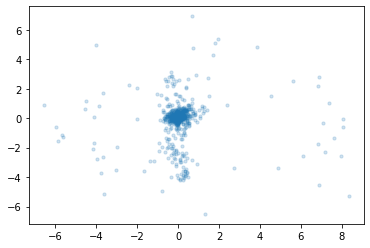

In [18]:
pca = PCA(n_components=3, whiten= True)
pca.fit(waves)
pca_data = pca.transform(waves)
plt.scatter(pca_data[:, 0], pca_data[:, 1], 10, alpha = 0.2)

(<Figure size 1440x1440 with 16 Axes>,
 array([[<AxesSubplot:title={'center':'Channel 0'}>,
         <AxesSubplot:title={'center':'Channel 1'}>,
         <AxesSubplot:title={'center':'Channel 2'}>,
         <AxesSubplot:title={'center':'Channel 3'}>],
        [<AxesSubplot:title={'center':'Channel 4'}>,
         <AxesSubplot:title={'center':'Channel 5'}>,
         <AxesSubplot:title={'center':'Channel 6'}>,
         <AxesSubplot:title={'center':'Channel 7'}>],
        [<AxesSubplot:title={'center':'Channel 8'}>,
         <AxesSubplot:title={'center':'Channel 9'}>,
         <AxesSubplot:title={'center':'Channel 10'}>,
         <AxesSubplot:title={'center':'Channel 11'}>],
        [<AxesSubplot:title={'center':'Channel 12'}>,
         <AxesSubplot:title={'center':'Channel 13'}>,
         <AxesSubplot:title={'center':'Channel 14'}>,
         <AxesSubplot:title={'center':'Channel 15'}>]], dtype=object))

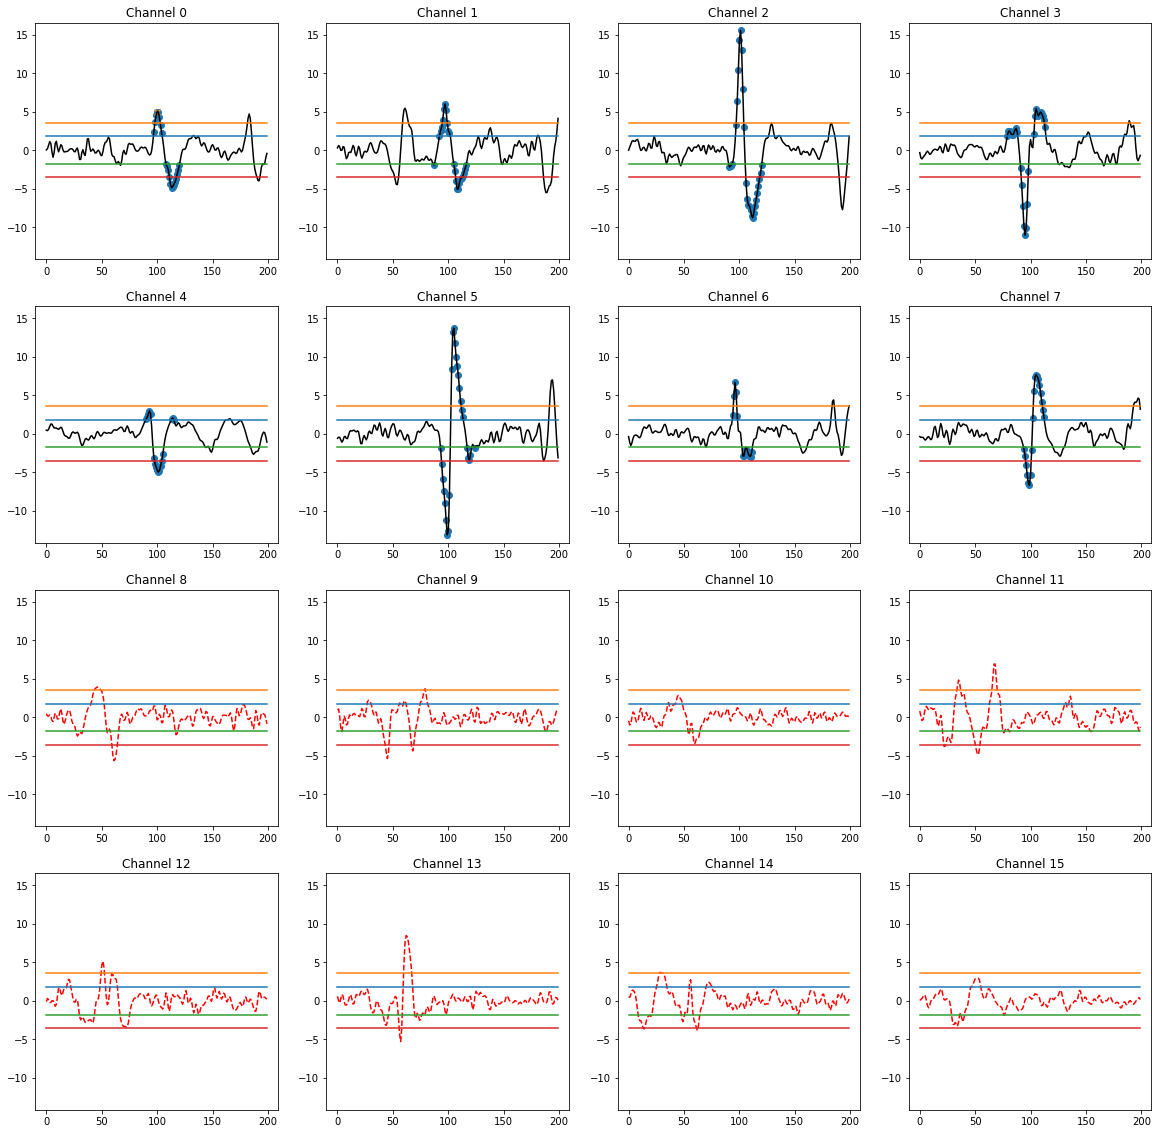

In [19]:
ffReal.plotSpk(100)

In [20]:
from sklearn.cluster import KMeans
clus = KMeans(n_clusters=5, random_state=0).fit(pca_data)

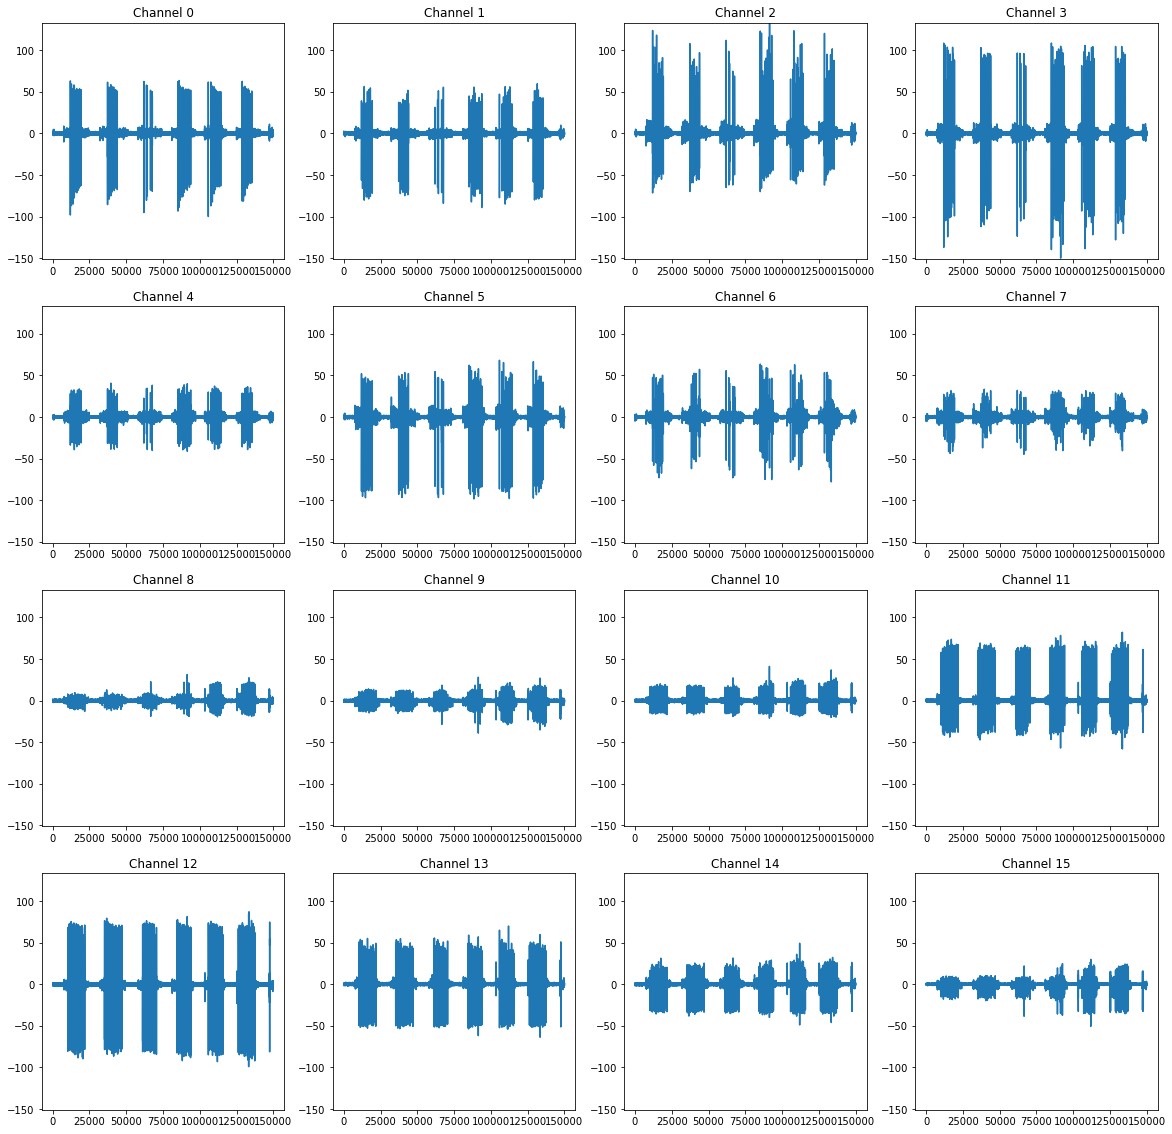

(<Figure size 1440x1440 with 16 Axes>,
 array([[<AxesSubplot:title={'center':'Channel 0'}>,
         <AxesSubplot:title={'center':'Channel 1'}>,
         <AxesSubplot:title={'center':'Channel 2'}>,
         <AxesSubplot:title={'center':'Channel 3'}>],
        [<AxesSubplot:title={'center':'Channel 4'}>,
         <AxesSubplot:title={'center':'Channel 5'}>,
         <AxesSubplot:title={'center':'Channel 6'}>,
         <AxesSubplot:title={'center':'Channel 7'}>],
        [<AxesSubplot:title={'center':'Channel 8'}>,
         <AxesSubplot:title={'center':'Channel 9'}>,
         <AxesSubplot:title={'center':'Channel 10'}>,
         <AxesSubplot:title={'center':'Channel 11'}>],
        [<AxesSubplot:title={'center':'Channel 12'}>,
         <AxesSubplot:title={'center':'Channel 13'}>,
         <AxesSubplot:title={'center':'Channel 14'}>,
         <AxesSubplot:title={'center':'Channel 15'}>]], dtype=object))

In [21]:
plot_dummy_data(data.transpose())

In [22]:
%matplotlib auto
plt.plot(data[:,0])
labels = clus.labels_
for i in range(5):
    ixs = labels == i 
    spkOfI = ffReal.spk[0][ixs]
    plt.scatter(spkOfI, [100]*len(spkOfI))
plt.xlim(10000, 30000)
plt.show()

Using matplotlib backend: MacOSX


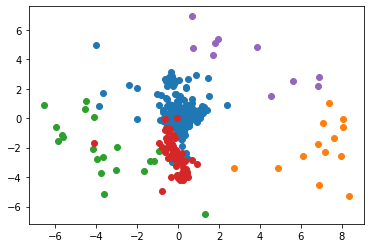

In [23]:
%matplotlib inline
plt.figure()
labels = clus.labels_
for i in range(5):
    ixs = labels == i 
    x = pca_data[ixs,0]
    y = pca_data[ixs,1]
    plt.scatter(x,y)

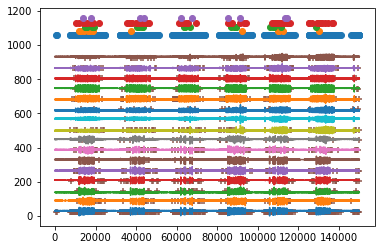

In [24]:
%matplotlib inline
plt.figure() 
rowHeight = 50
rowOffset = 60 
for i in range(ffReal.data.shape[1]):
    tmpData = ffReal.data[:, i]
    maxH, minH = max(tmpData), min(tmpData)
    b = (tmpData - np.min(tmpData))/np.ptp(tmpData)
    b *= rowHeight
    b += i * rowOffset
    plt.plot(b)
    
for i in range(5):
    ixs = labels == i 
    spkOfI = ffReal.spk[0][ixs]
    plt.scatter(spkOfI, [ffReal.data.shape[1]*rowOffset*1.1+(i*25)]*len(spkOfI))
    
x = [a[0][0] for a in ffReal.spk[1]]
y = [a[0][1]*rowOffset+rowHeight/2 for a in ffReal.spk[1]]
plt.scatter(x,y, marker ='+')

In [25]:
%matplotlib inline

In [26]:
from scipy.ndimage.measurements import center_of_mass

bruh = np.split(np.asarray(ff.waves[0]), 16)
bruh = np.asarray(bruh)
center_of_mass(bruh)

(-11.216740800268047, 366.4391047430128)

In [27]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(waves)
    distortions.append(kmeanModel.inertia_)

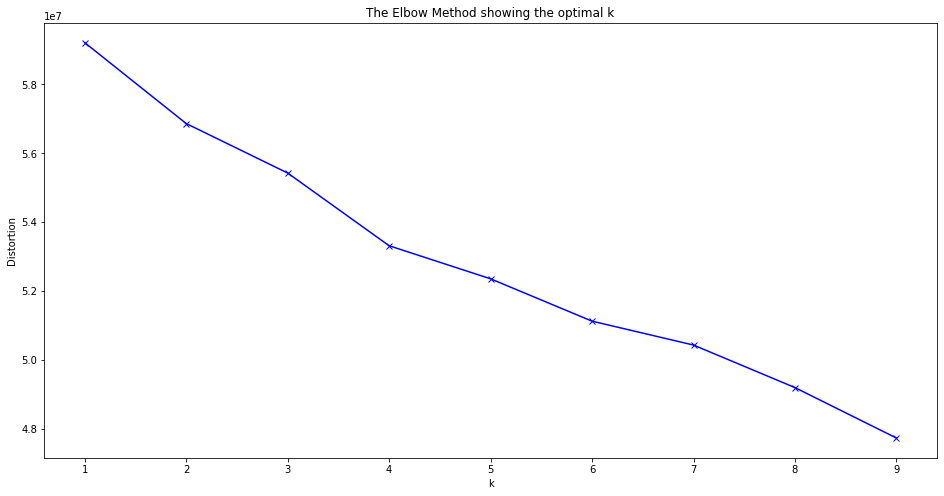

In [28]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [29]:
%matplotlib auto
labels = clus.labels_
ixs = labels == 2
wavTmp = np.asarray(ffReal.waves)[ixs]
for i in wavTmp:
    plt.plot(i)

plt.figure()
plt.scatter(pca_data[:,0], pca_data[:,1])
ixs = labels == 2 
x = pca_data[ixs,0]
y = pca_data[ixs,1]
plt.scatter(x,y)

Using matplotlib backend: MacOSX


In [30]:
from scipy import signal
# https://stackoverflow.com/questions/41492882/find-time-shift-of-two-signals-using-cross-correlation/56432463
y2 = wavTmp[2]
y1 = wavTmp[1]
n = len(y1)
corr = signal.correlate(y2, y1, mode='same') / np.sqrt(signal.correlate(y1, y1, mode='same')[int(n/2)] * signal.correlate(y2, y2, mode='same')[int(n/2)])
corr

array([-0.00144868, -0.00037158,  0.00072321, ..., -0.01136561,
       -0.0145797 , -0.01645993])

In [31]:
sr = 30000
delay_arr = np.linspace(-0.5*n/sr, 0.5*n/sr, n)
delay = np.argmax(corr) - len(corr) / 2 
delay

5.0

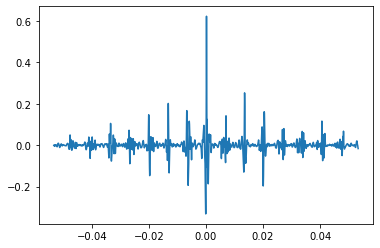

In [32]:
%matplotlib inline
plt.plot(delay_arr, corr)

([<matplotlib.lines.Line2D at 0x7feaec7fc7f0>],
 [<matplotlib.lines.Line2D at 0x7feaec7fcb50>])

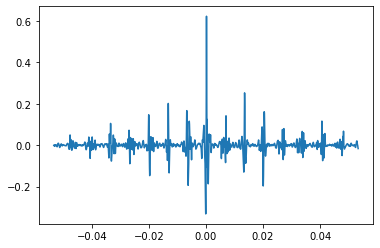

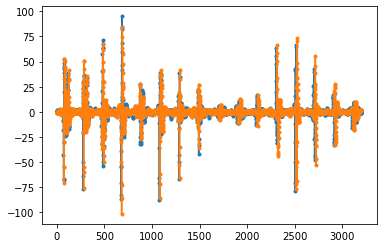

In [33]:
%matplotlib inline
plt.plot(delay_arr, corr)
plt.figure()
plt.plot(y1, '.-'), plt.plot(y2, '.-')

([<matplotlib.lines.Line2D at 0x7feacc55a4c0>],
 [<matplotlib.lines.Line2D at 0x7feb5cce2c70>])

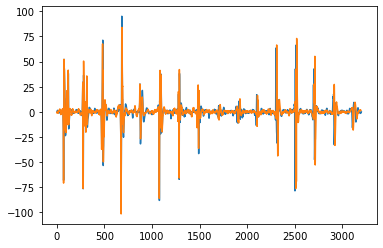

In [34]:
plt.figure() 
plt.plot(y1), plt.plot(y2[int(delay):])

In [35]:
# Better clustering
# Detect spikes and concatenate channels w/ noise and waveforms 
# # Double check concatenation, make sure noie replacement is actually happening 
# Run PCA and K-Means 

# Cross Correlation Alignment 
# Find time shift between each pair 
# Truncate second waveform by offset
# Add gaussian noise to pad truncated second waveform

# Checking for merges 
# Create a template, average across timepoints: One averaged waveform as long as all the waveforms
# Distance metric between clusters between templates (averaged waveform)
# threshold, if sim > some threshold, decrease k by 1 (aka merge)

# Checking for splits
# Create a matrix 
# Spk x Spk (where spks are in a given cluster) (# of clus = # of matricies)
# ith, jth element = distance between ith spk and jth spk in cluster
# hope that matrix would converge to zero across all values
# If [metric] > threshold, increase k by 1 (aka split)

# repeat above from step 2 [until k stays the same or max itr]
# Keep track of number of changes in assignments 

In [36]:
dummy_adj = [
    [0,1],
    [1,0],
    [1,2],
    [2,1],
    [2,3],
    [3,2],
    [3,4],
    [4,3],
    [4,5],
    [5,4],
    [5,6],
    [6,5],
    [6,7],
    [7,6],
]
tmp = [[x+8, y+8] for x,y in dummy_adj[:]]
d_adj = []
for i in dummy_adj:
    d_adj.append(i)
for i in tmp:
    d_adj.append(i)
d_adj = np.asarray(d_adj)
d_adj

array([[ 0,  1],
       [ 1,  0],
       [ 1,  2],
       [ 2,  1],
       [ 2,  3],
       [ 3,  2],
       [ 3,  4],
       [ 4,  3],
       [ 4,  5],
       [ 5,  4],
       [ 5,  6],
       [ 6,  5],
       [ 6,  7],
       [ 7,  6],
       [ 8,  9],
       [ 9,  8],
       [ 9, 10],
       [10,  9],
       [10, 11],
       [11, 10],
       [11, 12],
       [12, 11],
       [12, 13],
       [13, 12],
       [13, 14],
       [14, 13],
       [14, 15],
       [15, 14]])

/Users/samir/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


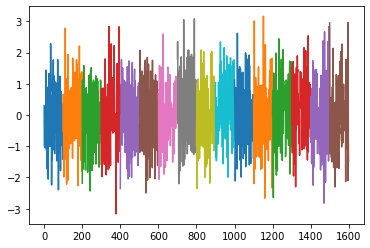

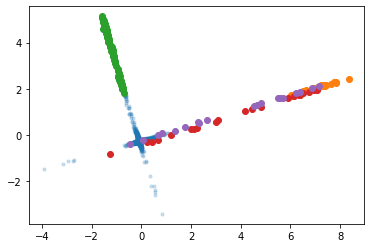

In [37]:
# Create function that takes in floodfill object and outputs time shifted waveforms with nosie padding
def waveshift(flood, wavDur = 100, sr = 30000, vis = False):
    %matplotlib inline
    import matplotlib.pyplot as plt 
    # Run PCA on data 
    from sklearn.decomposition import PCA
    waves = flood.getWave(wavDur)
    if vis: 
        plt.figure()
        flood.plotWaves(np.random.choice(len(waves)), 100)
    
    # Run PCA 
    from sklearn.cluster import KMeans
    pca = PCA(n_components=3, whiten= True)
    pca.fit(waves)
    pca_data = pca.transform(waves)
    if vis:
        plt.figure()
        plt.scatter(pca_data[:, 0], pca_data[:, 1], 10, alpha = 0.2)
    
    
    # Run KMeans
    from sklearn.cluster import KMeans
    clus = KMeans(n_clusters=5, random_state=0).fit(pca_data)

    # Cross corr alignments 
    from scipy import signal 
    newWavs = []
    labels = clus.labels_ 
    
    if vis:
        for i in range(1,max(labels)+1):
            ixs = labels == i 
            x = pca_data[ixs,0]
            y = pca_data[ixs,1]
            plt.scatter(x,y)

    for i in range(max(labels)+1):
        # Getting all the waveforms to a specific cluster 
        ixs = labels == i 
        wavTmp = np.asarray(waves)[ixs]
        y1 = wavTmp[0]
        tmp = [y1]
        for y2 in wavTmp: 
            # Calculating time offset between two signals 
            corr = signal.correlate(y2, y1, mode='same') / np.sqrt(signal.correlate(y1, y1, mode='same')[int(n/2)] * signal.correlate(y2, y2, mode='same')[int(n/2)])
            delay_arr = np.linspace(-0.5*n/sr, 0.5*n/sr, n)
            delay = np.argmax(corr) - len(corr) / 2 
            pad = np.random.randn(np.abs(int(delay)))
            if delay > 0:
                # Cutting off from the front
                y2 = y2[int(delay):]
                y2 = np.concatenate((pad, y2))
            elif delay < 0:
                # Cutting off from the back
                delay = np.abs(delay)
                y2 = y2[:-int(delay)]
                y2 = np.concatenate((y2, pad))
            tmp.append(y2)
        newWavs.append(tmp)
    return newWavs

ffReal = FloodFill(data, d_adj)
ffReal.detect_spikes(refr=5) 
thing = waveshift(ffReal, vis=True)

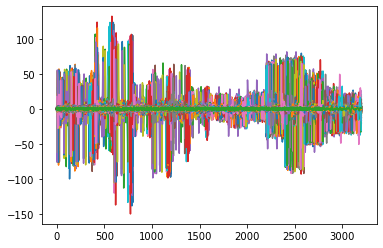

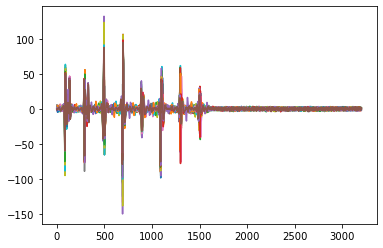

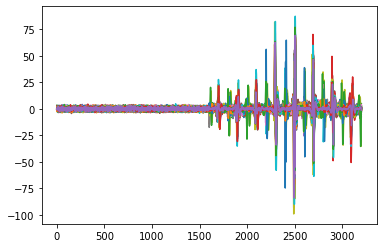

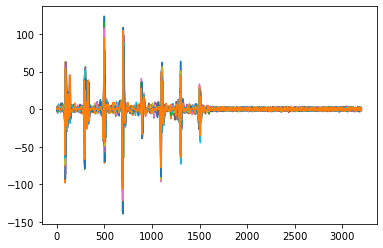

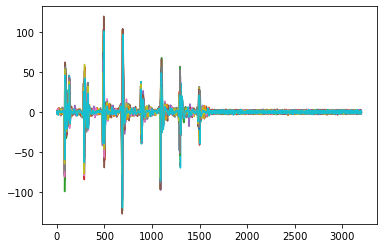

In [38]:
%matplotlib inline
#plt.figure()
for j in thing:
    plt.figure()
    for i in j:
        plt.plot(i)

Starting with 0
Comparing against  0


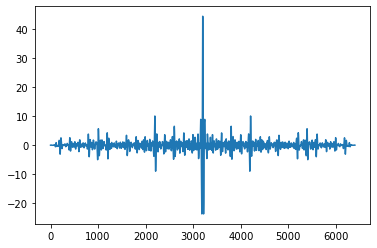

Comparing against  1


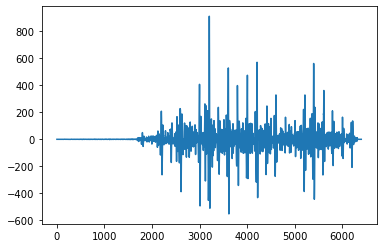

Comparing against  2


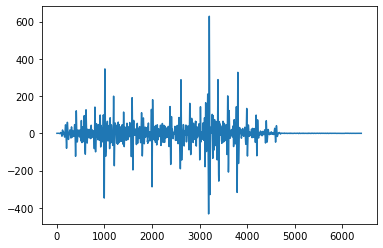

Comparing against  3


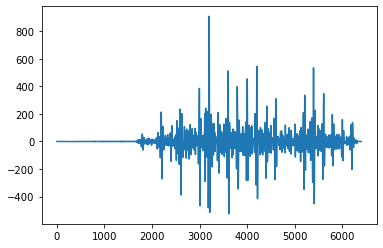

Comparing against  4


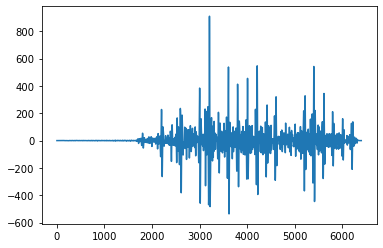

Starting with 1
Comparing against  0


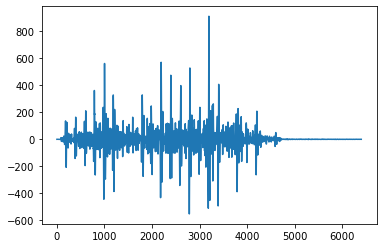

Comparing against  1


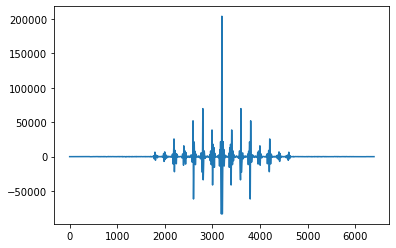

Comparing against  2


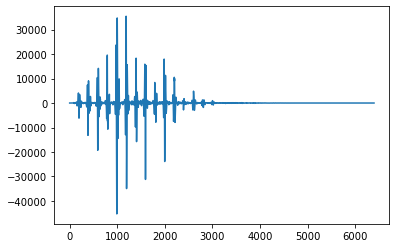

Comparing against  3


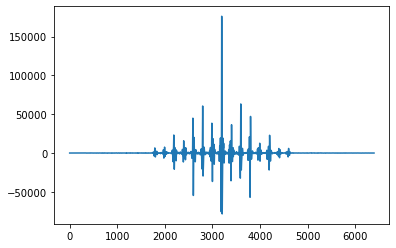

Comparing against  4


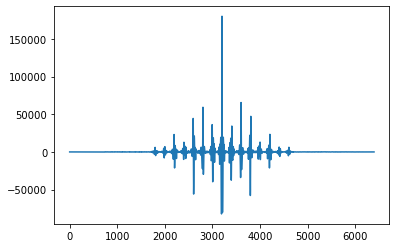

Starting with 2
Comparing against  0


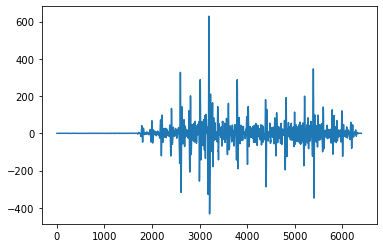

Comparing against  1


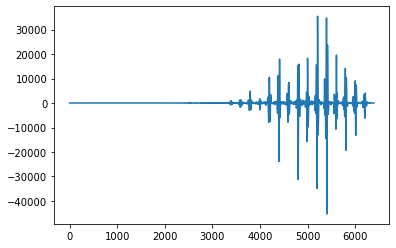

Comparing against  2


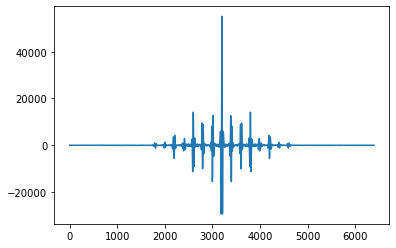

Comparing against  3


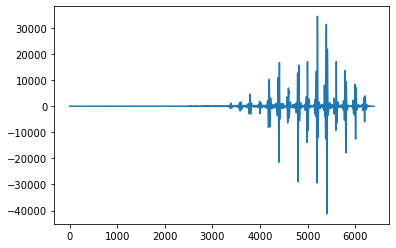

Comparing against  4


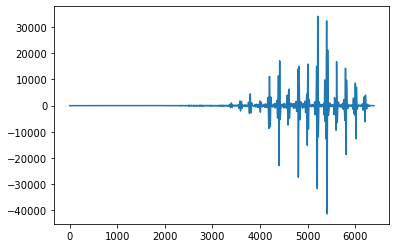

Starting with 3
Comparing against  0


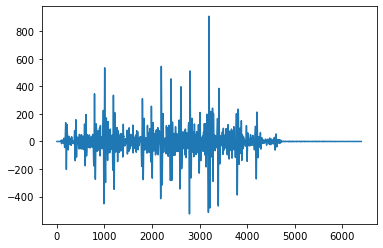

Comparing against  1


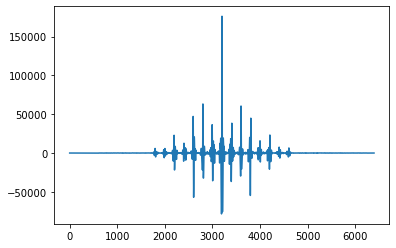

Comparing against  2


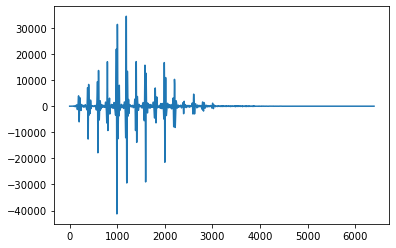

Comparing against  3


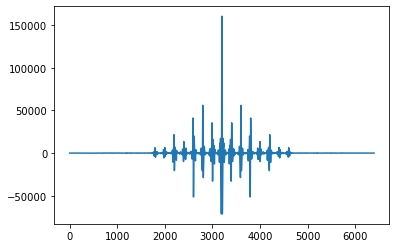

Comparing against  4


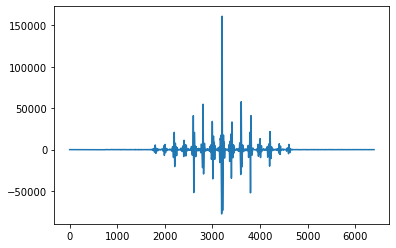

Starting with 4
Comparing against  0


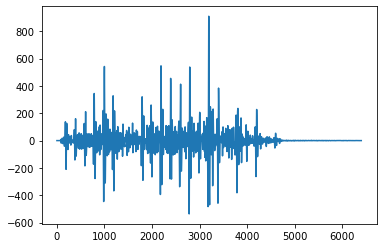

Comparing against  1


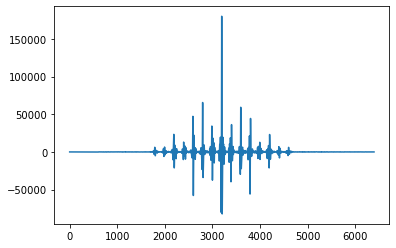

Comparing against  2


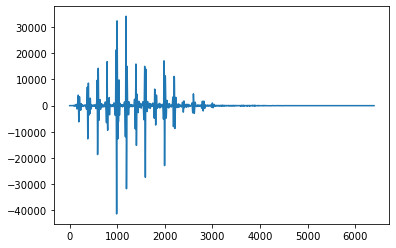

Comparing against  3


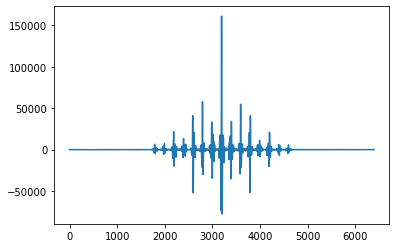

Comparing against  4


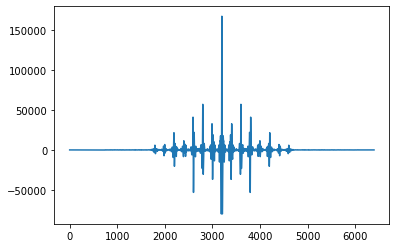

In [39]:
%matplotlib inline 
for i, clus in enumerate(thing): 
    print('Starting with', i)
    avgWav = sum([x for x in clus]) / len(clus)
    for j, comp in enumerate(thing):
        print('Comparing against ', j)
        avgComp = sum([x for x in comp]) / len(comp)
        plt.figure()
        plt.plot(signal.correlate(avgWav, avgComp))
        plt.show()

In [40]:
print('x')

x


In [41]:
min(len(x) for x in thing[0]) 

3200

In [42]:
ffReal.data.shape[1]

16

In [43]:
wav = ffReal.getWave(100)

In [44]:
np.random.choice(len(wav))

450

In [45]:
import vis

In [47]:
visualizer = vis.vis(ffReal)

In [49]:
visualizer.plotSpk(0)

AttributeError: 'vis' object has no attribute 'spk'